In [1]:
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# from reinforcement_model.baseline import SimpleClassifier
import torch.optim as optim
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
# from reinforcement_model.dataset import CommitDataset
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Any
from tree_sitter import Parser, Node
from pandarallel import pandarallel
import multiprocessing
from sklearn.manifold import TSNE
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
multiprocessing.cpu_count()
pandarallel.initialize(progress_bar=True, nb_workers=8)
# import sys
# sys.setrecursionlimit()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
neg = pd.read_csv(r'./datasets/ffmpeg.csv')
pos = pd.read_csv(r'./datasets/qemu.csv', encoding='utf_8_sig')

In [3]:
df = pd.concat([neg[['commit_msg','patch','vulnerability']],pos[['commit_msg','patch','vulnerability']]],axis=0)
df.fillna('', inplace=True)
# 1是100%的意思
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.rename(columns={'vulnerability':'label','patch':'diff','commit_msg':'message'},inplace=True)
df 

,message,diff,label
0,jpeg2000dec: dont set ncomponents to an inval...,diff --git a/libavcodec/jpeg2000dec.c b/libavc...,0
1,block: convert ThrottleGroup to object with Q...,diff --git a/block/throttle-groups.c b/block/t...,0
2,MIPS: fix yield handling The parameter for yi...,diff --git a/target-mips/op_helper.c b/target-...,0
3,jvdec: avoid unsigned overflow in comparison ...,diff --git a/libavformat/jvdec.c b/libavformat...,1
4,qemu-img: print short help on getopt failure ...,diff --git a/qemu-img.c b/qemu-img.c\nindex c7...,1
...,...,...,...
25868,migration: don't close a file descriptor whil...,diff --git a/migration/migration.c b/migration...,1
25869,"Simplify left_xy content for the loop filter,...",diff --git a/libavcodec/h264.h b/libavcodec/h2...,0
25870,"Fix headers so that ""make checkheaders"" passe...",diff --git a/libavcodec/amr.h b/libavcodec/amr...,0
25871,intel-iommu: Check IOAPIC's Trigger Mode agai...,diff --git a/hw/i386/intel_iommu.c b/hw/i386/i...,0


In [4]:
from unidiff import PatchSet, UnidiffParseError
import io
def parse_single_diff(diff_text):
    parsed_diff = {}

    if not isinstance(diff_text, str) or not diff_text.strip():
        return parsed_diff

    try:
        patch = PatchSet(io.StringIO(diff_text))
    except UnidiffParseError:
        # print("Skipping invalid diff:", diff_text[:200])  # 仅打印前200字符
        return parsed_diff

    for file in patch:
        file_path = file.path
        added_lines = []
        removed_lines = []

        for hunk in file:
            for line in hunk:
                if line.is_added:
                    added_lines.append(line.value.strip())
                elif line.is_removed:
                    removed_lines.append(line.value.strip())

        if file_path not in parsed_diff:
            parsed_diff[file_path] = {'added': [], 'removed': []}
        parsed_diff[file_path]['added'].extend(added_lines)
        parsed_diff[file_path]['removed'].extend(removed_lines)

    return parsed_diff


In [5]:
# df['code_diff'] = df['diff'].map(lambda  x : parse_single_diff(x)) 

In [6]:
def extract_before_after_code(diff_text):
    parsed_diff = {}

    try:
        patch = PatchSet(io.StringIO(diff_text))
    except UnidiffParseError:
        return {}

    for file in patch:
        file_path = file.path

        code_before_lines = []
        code_after_lines = []
        
        for hunk in file:
            for line in hunk:
                if line.is_added:
                    code_after_lines.append(line.value.strip())
                elif line.is_removed:
                    code_before_lines.append(line.value.strip())
                elif not (line.is_added or line.is_removed):  # 上下文行
                    code_before_lines.append(line.value.strip())
                    code_after_lines.append(line.value.strip())

        code_before = '\n'.join(code_before_lines) if code_before_lines else None
        code_after = '\n'.join(code_after_lines) if code_after_lines else None

        parsed_diff[file_path] = (code_before, code_after)

    return parsed_diff

In [7]:
# df['before_after'] = df['diff'].map(lambda  x : extract_before_after_code(x)) 

In [8]:
import io
from unidiff import PatchSet, UnidiffParseError
from tree_sitter import Language, Parser
Language.build_library(
    'build/my-languages.so',  # 输出的动态链接库
    [
        'tree-sitter-python',  # Python 语法
        'tree-sitter-java',    # Java 语法
        'tree-sitter-javascript',  # JavaScript 语法
        'tree-sitter-php/php',
        'tree-sitter-perl',
        'tree-sitter-c',
        # 'tree-sitter-markdown',
        'tree-sitter-ruby',
        'tree-sitter-cpp',
        # 'tree-sitter-xml/xml',
        'tree-sitter-yaml',
        'tree-sitter-go',
        'tree-sitter-rust'
        # 添加更多语言...
    ]
)

/root/miniconda3/lib/python3.12/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language.build_library is deprecated. Use the new bindings instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


False

In [9]:

# 加载支持的语言库
LANGUAGE_MAPPING = {
    'python': Language('build/my-languages.so', 'python'),
    'java': Language('build/my-languages.so', 'java'),
    'javascript': Language('build/my-languages.so', 'javascript'),
    'php': Language('build/my-languages.so', 'php'),
    'perl': Language('build/my-languages.so', 'perl'),
    'c': Language('build/my-languages.so', 'c'),
    # 'md': Language('build/my-languages.so', 'markdown'),
    'rb': Language('build/my-languages.so', 'ruby'),
    'cpp': Language('build/my-languages.so', 'cpp'),
    # 'xml': Language('build/my-languages.so', 'xml'),
    'yml': Language('build/my-languages.so', 'yaml'),
    'go': Language('build/my-languages.so', 'go'),
    'rst': Language('build/my-languages.so', 'rust'),
    # 可以继续扩展更多语言
}

def get_language_by_extension(file_path):
    if file_path.endswith('.py'):
        return 'python'
    elif file_path.endswith('.java'):
        return 'java'
    elif file_path.endswith('.js'):
        return 'javascript'
    elif file_path.endswith('.php'):
        return 'php'
    elif file_path.endswith('.cgi'):
        return 'perl'
    elif file_path.endswith('.c'):
        return 'c'
    # elif file_path.endswith('.md'):
    #     return 'md'
    elif file_path.endswith('.rb'):
        return 'rb'
    elif file_path.endswith('.cpp'):
        return 'cpp'
    # elif file_path.endswith('.xml'):
    #     return 'xml'
    elif file_path.endswith('.yml'):
        return 'yml'
    elif file_path.endswith('.go'):
        return 'go'
    # elif file_path.endswith('.rst'):
    #     return 'rst'
    else:
        return None  # 不支持的语言

/root/miniconda3/lib/python3.12/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


In [10]:
def build_ast_tree(code: str, parser: Parser, language: Any) -> Dict:
    """构建单个代码文件的AST树结构"""
    if not code:
        return None
    
    tree = parser.parse(bytes(code, "utf8"))
    root_node = tree.root_node
    
    def traverse(node: Node) -> Dict:
        """递归遍历AST节点"""
        node_dict = {
            'type': node.type,
            'text': node.text.decode('utf8') if node.text else '',
            'children': []
        }
        
        for child in node.children:
            if child.is_named:  # 只包含有名称的节点
                node_dict['children'].append(traverse(child))
                
        return node_dict
    
    return traverse(root_node) if root_node else None

def extract_commit_level_ast(diff_text: str) -> Dict:
    """提取commit级别的AST信息"""
    if not isinstance(diff_text, str) or not diff_text.strip():
        return {'commit': {'files': {}, 'ast_before': {}, 'ast_after': {}}}
    
    try:
        patch = PatchSet(io.StringIO(diff_text))
        # print('===========',patch)
        # print('diff_text',diff_text)
    except UnidiffParseError:
        
        return {'commit': {'files': {}, 'ast_before': {}, 'ast_after': {}}}
        
    commit_ast = {
        'files': {},
        'ast_before': {},
        'ast_after': {}
    }

    for file in patch:
        file_path = file.path
        # print("sad asd as sa",file_path)
        lang_key = get_language_by_extension(file_path)

        if not lang_key or lang_key not in LANGUAGE_MAPPING:
            continue

        parser = Parser()
        parser.set_language(LANGUAGE_MAPPING[lang_key])

        # 收集修改前后的代码
        code_before_lines = []
        code_after_lines = []
        
        for hunk in file:
            for line in hunk:
                if line.is_added:
                    code_after_lines.append(line.value)
                elif line.is_removed:
                    code_before_lines.append(line.value)
                else:  # 上下文行
                    code_before_lines.append(line.value)
                    code_after_lines.append(line.value)

        code_before = '\n'.join(code_before_lines) if code_before_lines else None
        code_after = '\n'.join(code_after_lines) if code_after_lines else None
        # print("=============",code_before,code_after)
        # 构建AST树
        ast_before = build_ast_tree(code_before, parser, LANGUAGE_MAPPING[lang_key])
        ast_after = build_ast_tree(code_after, parser, LANGUAGE_MAPPING[lang_key])

        # 存储文件信息
        commit_ast['files'][file_path] = {
            'language': lang_key,
            'code_before': code_before,
            'code_after': code_after
        }

        # 存储AST信息
        if ast_before:
            commit_ast['ast_before'][file_path] = ast_before
        if ast_after:
            commit_ast['ast_after'][file_path] = ast_after

    return {'commit': commit_ast}

def extract_commit_level_ast_for_df(diff_text: str) -> Tuple[Dict, Dict]:
    """为DataFrame设计的commit级别AST提取函数，返回两列数据"""
    result = extract_commit_level_ast(diff_text)
    commit_data = result.get('commit', {})
    return commit_data.get('ast_before', {}), commit_data.get('ast_after', {})
    

In [11]:
# df['graph_before'], df['graph_after'] = zip(*df['diff'].map(extract_commit_level_ast_for_df))

In [12]:
df[['graph_before','graph_after']] = df['diff'].parallel_apply(lambda x: pd.Series(extract_commit_level_ast_for_df(x)))

In [13]:
df

,message,diff,label,graph_before,graph_after
0,jpeg2000dec: dont set ncomponents to an inval...,diff --git a/libavcodec/jpeg2000dec.c b/libavc...,0,{},{}
1,block: convert ThrottleGroup to object with Q...,diff --git a/block/throttle-groups.c b/block/t...,0,{'block/throttle-groups.c': {'type': 'translat...,{'block/throttle-groups.c': {'type': 'translat...
2,MIPS: fix yield handling The parameter for yi...,diff --git a/target-mips/op_helper.c b/target-...,0,{'target-mips/op_helper.c': {'type': 'translat...,{'target-mips/op_helper.c': {'type': 'translat...
3,jvdec: avoid unsigned overflow in comparison ...,diff --git a/libavformat/jvdec.c b/libavformat...,1,{},{}
4,qemu-img: print short help on getopt failure ...,diff --git a/qemu-img.c b/qemu-img.c\nindex c7...,1,"{'qemu-img.c': {'type': 'translation_unit', 't...","{'qemu-img.c': {'type': 'translation_unit', 't..."
...,...,...,...,...,...
25868,migration: don't close a file descriptor whil...,diff --git a/migration/migration.c b/migration...,1,{'migration/migration.c': {'type': 'translatio...,{'migration/migration.c': {'type': 'translatio...
25869,"Simplify left_xy content for the loop filter,...",diff --git a/libavcodec/h264.h b/libavcodec/h2...,0,{},{}
25870,"Fix headers so that ""make checkheaders"" passe...",diff --git a/libavcodec/amr.h b/libavcodec/amr...,0,{},{}
25871,intel-iommu: Check IOAPIC's Trigger Mode agai...,diff --git a/hw/i386/intel_iommu.c b/hw/i386/i...,0,{'hw/i386/intel_iommu.c': {'type': 'translatio...,{'hw/i386/intel_iommu.c': {'type': 'translatio...


In [14]:
from unidiff import PatchSet, UnidiffParseError
import io
def parse_single_diff(diff_text):
    parsed_diff = {}

    if not isinstance(diff_text, str) or not diff_text.strip():
        return parsed_diff

    try:
        patch = PatchSet(io.StringIO(diff_text))
    except UnidiffParseError:
        # print("Skipping invalid diff:", diff_text[:200])  # 仅打印前200字符
        return parsed_diff

    for file in patch:
        file_path = file.path
        added_lines = []
        removed_lines = []

        for hunk in file:
            for line in hunk:
                if line.is_added:
                    added_lines.append(line.value.strip())
                elif line.is_removed:
                    removed_lines.append(line.value.strip())

        if file_path not in parsed_diff:
            parsed_diff[file_path] = {'added': [], 'removed': []}
        parsed_diff[file_path]['added'].extend(added_lines)
        parsed_diff[file_path]['removed'].extend(removed_lines)

    return parsed_diff


In [15]:
df['code_diff'] = df['diff'].map(lambda  x : parse_single_diff(x)) 

In [16]:
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool,GlobalAttention
from typing import Dict, List

class ASTGraphBuilder:
    def __init__(self):
        self.node_counter = 0
        self.nodes = []
        self.edges = []
        self.node_type_map = {}
    
    def reset(self):
        self.node_counter = 0
        self.nodes = []
        self.edges = []
        self.node_type_map = {}

    def traverse_ast_dict(self, ast_dict: Dict, parent_idx: int = None):
        """递归遍历AST字典结构构建图"""
        if ast_dict is None:
            return
        
        # 处理当前节点
        current_idx = self.node_counter
        self.node_counter += 1
        
        node_type = ast_dict['type']
        if node_type not in self.node_type_map:
            self.node_type_map[node_type] = len(self.node_type_map)
        
        self.nodes.append(node_type)
        
        # 添加与父节点的边
        if parent_idx is not None:
            self.edges.append((parent_idx, current_idx))
        
        # 递归处理子节点
        for child in ast_dict.get('children', []):
            self.traverse_ast_dict(child, current_idx)

def dict_ast_to_graph(ast_dict: Dict) -> Data:
    """将字典形式的AST转换为图数据"""
    builder = ASTGraphBuilder()
    builder.traverse_ast_dict(ast_dict)
    
    if not builder.nodes:
        return Data(x=torch.zeros((1, 1)), edge_index=torch.zeros((2, 0), dtype=torch.long))
    
    # 创建节点特征和边索引
    x = torch.tensor([builder.node_type_map[t] for t in builder.nodes], dtype=torch.long)
    edge_index = torch.tensor(builder.edges, dtype=torch.long).t().contiguous() if builder.edges else torch.zeros((2, 0), dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index)

class CommitGCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.emb = torch.nn.Embedding(in_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.att_pool = GlobalAttention(
            gate_nn=nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, 1)
            )
        )
        
    def forward_single_graph(self, data: Data):
        x, edge_index = data.x, data.edge_index
        x = self.emb(x)
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        batch = torch.zeros(x.size(0), dtype=torch.long)
        return self.att_pool(x, batch)
    
    def forward_file_ast(self, ast_dict: Dict):
        """处理单个文件的AST字典"""
        graph = dict_ast_to_graph(ast_dict)
        return self.forward_single_graph(graph)
    
    def forward_commit(self, ast_before: Dict, ast_after: Dict):
        """处理整个commit的前后AST"""
        file_embeddings_before = []
        file_embeddings_after = []
        
        all_files = set(ast_before.keys()).union(set(ast_after.keys()))
        
        for file_path in all_files:
            # 处理修改前的AST
            if file_path in ast_before and ast_before[file_path]:
                emb_before = self.forward_file_ast(ast_before[file_path])
                # 确保所有张量都是二维的 [1, out_dim]
                if emb_before.dim() == 1:
                    emb_before = emb_before.unsqueeze(0)
                file_embeddings_before.append(emb_before)
            else:
                file_embeddings_before.append(torch.zeros(1, self.conv2.out_channels))
            
            # 处理修改后的AST
            if file_path in ast_after and ast_after[file_path]:
                emb_after = self.forward_file_ast(ast_after[file_path])
                # 确保所有张量都是二维的 [1, out_dim]
                if emb_after.dim() == 1:
                    emb_after = emb_after.unsqueeze(0)
                file_embeddings_after.append(emb_after)
            else:
                file_embeddings_after.append(torch.zeros(1, self.conv2.out_channels))
        
        # 堆叠前确保所有张量形状一致
        if file_embeddings_before:
            h_before = torch.cat(file_embeddings_before, dim=0).mean(dim=0)
        else:
            h_before = torch.zeros(self.conv2.out_channels)
        
        if file_embeddings_after:
            h_after = torch.cat(file_embeddings_after, dim=0).mean(dim=0)
        else:
            h_after = torch.zeros(self.conv2.out_channels)
        
        # 组合差异嵌入
        # diff_embedding = torch.cat([h_before], dim=-1).detach()
        # diff_embedding = torch.cat([h_before, h_after], dim=-1).detach()
        diff_embedding = torch.cat([h_before, h_after-h_before], dim=-1).detach()
        return diff_embedding

In [17]:
# 对整个DataFrame应用
model = CommitGCN(in_dim=128, hidden_dim=32, out_dim=32)
df['embedding'] = df.apply(lambda row: model.forward_commit(row['graph_before'], row['graph_after']), axis=1)

/tmp/ipykernel_2002/838689584.py:63: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  self.att_pool = GlobalAttention(


In [18]:
import numpy as np
def to_numpy_vector(x):
    if isinstance(x, torch.Tensor):
        return x.numpy()
    elif isinstance(x, list) and isinstance(x[0], torch.Tensor):
        return torch.stack(x).numpy()
    elif isinstance(x, list) and isinstance(x[0], float):
        return np.array(x)
    else:
        raise TypeError(f"Unsupported type: {type(x)} -> {x}")

In [19]:
# 先转换为 numpy 向量
df['embedding_np'] = df['embedding'].apply(to_numpy_vector)

# 拼成矩阵
X = np.stack(df['embedding_np'].values)

# 聚类
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
distances = kmeans.fit_transform(X)  # 获取每个点到各聚类中心的距离

# 将距离转换为概率（使用softmax）
soft_labels = np.exp(-distances) / np.sum(np.exp(-distances), axis=1, keepdims=True)
df['soft_labels'] = list(soft_labels)

In [20]:
# df['soft_labels']

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from tqdm.auto import tqdm

# 1. 定义数据集类
class CommitDataset(Dataset):
    def __init__(self, messages, cluster_labels, labels, diffs, tokenizer, diff_tokenizer, max_length=128):
        self.messages = messages
        self.cluster_labels = cluster_labels
        self.labels = labels
        self.diffs = diffs
        self.tokenizer = tokenizer
        self.diff_tokenizer = diff_tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.messages)
    
    def __getitem__(self, idx):
        message = str(self.messages[idx])
        cluster_labels = self.cluster_labels[idx]
        label = self.labels[idx]
        diff = str(self.diffs[idx])
        
        # Tokenize the commit message
        message_encoding = self.tokenizer(
            message,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Tokenize the diff using the diff_tokenizer (CodeBERT)
        diff_encoding = self.diff_tokenizer(
            diff,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': message_encoding['input_ids'].flatten(),
            'attention_mask': message_encoding['attention_mask'].flatten(),
            'diff_input_ids': diff_encoding['input_ids'].flatten(),
            'diff_attention_mask': diff_encoding['attention_mask'].flatten(),
            'cluster_onehot': torch.tensor(cluster_labels, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.long)
        }
# 2. 定义模型
# CNN

class CommitClassifier(nn.Module):
    def __init__(self, bert_model_name, codebert_model_name, num_classes, 
                 cluster_dim=10, hidden_dim=256, dropout=0.1):
        """
        带聚类增强的提交分类模型
        
        参数:
            bert_model_name: 用于提交信息的BERT模型名称
            codebert_model_name: 用于代码差异的CodeBERT模型名称
            num_classes: 分类类别数
            cluster_dim: 聚类标签的维度(one-hot长度)
            hidden_dim: 隐藏层维度
            dropout: dropout率
        """
        super(CommitClassifier, self).__init__()
        
        # 文本(提交信息)编码器
        self.bert = AutoModel.from_pretrained(bert_model_name)
        
        # 代码(差异)编码器
        self.codebert = AutoModel.from_pretrained(codebert_model_name)
        
        self.dropout = nn.Dropout(dropout)
        
        # 获取各模态的隐藏维度
        bert_hidden_dim = self.bert.config.hidden_size
        codebert_hidden_dim = self.codebert.config.hidden_size
        
        # 投影层对齐维度
        self.text_proj = nn.Linear(bert_hidden_dim, hidden_dim)
        self.code_proj = nn.Linear(codebert_hidden_dim, hidden_dim)
        
        # 聚类标签处理层 - 保持原始维度不压缩
        self.cluster_proj = nn.Linear(cluster_dim, hidden_dim) if cluster_dim > 0 else None
        
        # 计算分类器输入维度
        classifier_input_dim = 2 * hidden_dim  # 文本 + 代码
        if cluster_dim > 0:
            classifier_input_dim += hidden_dim  # 加上聚类特征(不再压缩)
            
        # 最终分类器
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, input_ids, attention_mask, diff_input_ids, diff_attention_mask, cluster_labels=None):
        """
        前向传播
        
        参数:
            input_ids: 提交信息的token IDs
            attention_mask: 提交信息的attention mask
            diff_input_ids: 代码差异的token IDs
            diff_attention_mask: 代码差异的attention mask
            cluster_labels: 聚类标签的one-hot编码 (batch_size, cluster_dim)
        """
        # 处理提交信息
        text_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        text_pooled = text_output.pooler_output
        text_features = torch.relu(self.text_proj(text_pooled))
        
        # 处理代码差异
        code_output = self.codebert(
            input_ids=diff_input_ids,
            attention_mask=diff_attention_mask
        )
        code_pooled = code_output.pooler_output
        code_features = torch.relu(self.code_proj(code_pooled))
        
        # 处理聚类标签(如果提供)
        if cluster_labels is not None and self.cluster_proj is not None:
            cluster_features = torch.relu(self.cluster_proj(cluster_labels.float()))
        else:
            cluster_features = None
        
        # 组合所有特征
        if cluster_features is not None:
            combined = torch.cat((text_features, code_features, cluster_features), dim=1)
        else:
            combined = torch.cat((text_features, code_features), dim=1)
        
        combined = self.dropout(combined)
        
        # 分类
        logits = self.classifier(combined)
        return logits, combined


# EarlyStopping类保持不变
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

class Trainer:
    def __init__(self, model, train_loader, val_loader, device, learning_rate=2e-5, patience=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        self.best_model_path = 'best_model.pt'
        self.early_stopper = EarlyStopper(patience=3, min_delta=0.01)
    def train_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in tqdm(self.train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            diff_input_ids = batch['diff_input_ids'].to(self.device)
            diff_attention_mask = batch['diff_attention_mask'].to(self.device)
            cluster_labels = batch['cluster_onehot'].to(self.device)
            labels = batch['label'].to(self.device)
            
            self.optimizer.zero_grad()
            
            outputs, _ = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                diff_input_ids=diff_input_ids,
                diff_attention_mask=diff_attention_mask,
                cluster_labels=cluster_labels
            )
            
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = total_loss / len(self.train_loader)
        train_acc = correct / total
        
        return train_loss, train_acc

    # eval_model函数保持不变
    def eval_model(self,dataloader):
        model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        all_embeddings = []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                diff_input_ids = batch['diff_input_ids'].to(self.device)
                diff_attention_mask = batch['diff_attention_mask'].to(self.device)
                cluster_labels = batch['cluster_onehot'].to(self.device)
                labels = batch['label'].to(self.device)
                
                outputs, embeddings = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    diff_input_ids=diff_input_ids,
                    diff_attention_mask=diff_attention_mask,
                    cluster_labels=cluster_labels
                )
                
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_embeddings.extend(embeddings.cpu().numpy())
        
        return total_loss / len(dataloader), correct / total, all_preds, all_labels, all_embeddings
    
    def validate(self, dataloader=None):
        if dataloader is None:
            dataloader = self.val_loader
            
        return self.eval_model(dataloader)
    
    def train(self, epochs):
        for epoch in range(epochs):
            print(f'\nEpoch {epoch+1}/{epochs}')
            
            # 训练一个epoch
            train_loss, train_acc = self.train_epoch()
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
            
            # 验证
            val_loss, val_acc, _, _,_ = self.validate()
            print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
            
            # 早停检查
            if self.early_stopper.early_stop(val_loss):             
                break
        
        # 训练结束后加载最佳模型
        # self.model.load_state_dict(torch.load(self.best_model_path))
    
    def evaluate(self, test_loader):
        _, test_acc, test_preds, test_labels, test_embeddings = self.validate(test_loader)
        return test_acc, test_preds, test_labels, test_embeddings

    def plot_tsne(self, test_loader):
        labels = ['positive', 'negative']
        _, test_acc, test_preds, test_labels, test_embeddings = self.validate(test_loader)
        tsne = TSNE(n_components=2, random_state=42)
    
        # embeddings_np = test_embeddings  # Fixed this line
        embeddings_np = np.vstack(test_embeddings) 
        n_samples = embeddings_np.shape[0]
        # print("=======================",n_samples)
        # print(test_embeddings)
        # Apply t-SNE transformation
        embeddings_2d = tsne.fit_transform(embeddings_np)  # Changed to use embeddings_np
        df_tsne = pd.DataFrame(embeddings_2d, columns=['TSNE1', 'TSNE2'])
        
        # Apply KMeans
        kmeans_model = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(embeddings_np)
        cluster_labels = kmeans_model.labels_  # Changed from fit_predict to labels_
        
        df_tsne['Cluster'] = cluster_labels
        df_tsne['TrueLabel'] = test_labels  # Added true labels for comparison


        # Silhouette Score
        sil_score = silhouette_score(embeddings_np, cluster_labels)
        print("Silhouette Score:", sil_score)

        # Plot using `plt.plot`
        plt.figure(figsize=(8, 6))
        for cluster_id in df_tsne['Cluster'].unique():
            cluster_data = df_tsne[df_tsne['Cluster'] == cluster_id]
            plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], 
                       label=f'Cluster {cluster_id}')
        
        plt.title('Scatter plot of embeddings using KMeans Clustering')
        plt.xlabel('TSNE1')
        plt.ylabel('TSNE2')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()  # Changed from pause/clf to show for better visualizationlabels

        # 计算每个样本的 Silhouette 系数
        sample_silhouette_values = silhouette_samples(embeddings_np, cluster_labels)
        
        plt.figure(figsize=(10, 6))
        y_lower = 10
        for i in range(2):  # 2 是聚类个数
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / 2)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for spacing
        
        plt.axvline(x=sil_score, color="red", linestyle="--")
        plt.title("Silhouette Plot for KMeans Clustering")
        plt.xlabel("Silhouette Coefficient Values")
        plt.ylabel("Cluster Label")
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, test_loader, normalize=False, title='Confusion Matrix on Dataset I', cmap=plt.cm.Blues):
        classes = ['positive','negative']
        
        _, test_acc, test_preds, test_labels, test_embeddings = self.validate(test_loader)
        cm = confusion_matrix(test_labels, test_preds)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
    
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
    
        plt.ylabel('True label')
        # plt.xlabel('Predicted label')
        plt.tight_layout()



# 主函数
# def main():
# 配置参数
BERT_MODEL_NAME = './models/bert-base-uncased'
CODEBERT_MODEL_NAME = './models/codebert-base'
NUM_CLASSES = 2
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 2e-5
MAX_LENGTH = 512
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载数据
messages = df['message'].values
diff = df['code_diff'].values
cluster_labels = df['soft_labels'].values
labels = df['label'].values
print(f"messages shape: {messages.shape}")
print(f"cluster_vectors shape: {cluster_labels.shape}")

train_messages, temp_messages, train_diff, temp_diff, train_cluster_labels, temp_cluster_labels, train_labels, temp_labels = train_test_split(
    messages, diff, cluster_labels, labels, test_size=0.3, random_state=42
)

# 第二次划分：val + test（从 temp 中再拆）
val_messages, test_messages, val_diff, test_diff, val_cluster_labels, test_cluster_labels, val_labels, test_labels = train_test_split(
    temp_messages, temp_diff, temp_cluster_labels, temp_labels, test_size=0.5, random_state=42
)
# 初始化tokenizer
message_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
diff_tokenizer = AutoTokenizer.from_pretrained(CODEBERT_MODEL_NAME)
# 创建数据集和数据加载器
train_dataset = CommitDataset(
    messages=train_messages,
    cluster_labels=train_cluster_labels,
    labels=train_labels,
    diffs=train_diff,
    tokenizer=message_tokenizer,
    diff_tokenizer=diff_tokenizer,
    max_length=MAX_LENGTH
)

val_dataset = CommitDataset(
    messages=val_messages,
    cluster_labels=val_cluster_labels,
    labels=val_labels,
    diffs=val_diff,
    tokenizer=message_tokenizer,
    diff_tokenizer=diff_tokenizer,
    max_length=MAX_LENGTH
)
test_dataset = CommitDataset(
    messages=test_messages,
    cluster_labels=test_cluster_labels,
    labels=test_labels,
    diffs=test_diff,
    tokenizer=message_tokenizer,
    diff_tokenizer=diff_tokenizer,
    max_length=MAX_LENGTH
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 初始化模型和训练器
# model = CommitClassifier(
#     bert_model_name=BERT_MODEL_NAME,
#     codebert_model_name=CODEBERT_MODEL_NAME,
#     meta_dim=META_DIM,
#     num_classes=NUM_CLASSES
# )

# 初始化模型
model = CommitClassifier(
    bert_model_name=BERT_MODEL_NAME,
    codebert_model_name=CODEBERT_MODEL_NAME,
    num_classes=NUM_CLASSES,
    cluster_dim=2,  # 聚类类别数
)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    learning_rate=LEARNING_RATE,
    patience=3
)

# 训练模型
trainer.train(epochs=EPOCHS)



# if __name__ == '__main__':
#     main()

messages shape: (25873,)
cluster_vectors shape: (25873,)

Epoch 1/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Train Loss: 0.2929 | Train Acc: 0.8722


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.1074 | Val Acc: 0.9665

Epoch 2/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Train Loss: 0.0794 | Train Acc: 0.9777


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.0909 | Val Acc: 0.9771

Epoch 3/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Val Loss: 0.0611 | Val Acc: 0.9848

Epoch 4/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Train Loss: 0.0371 | Train Acc: 0.9904


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.0570 | Val Acc: 0.9871

Epoch 5/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Train Loss: 0.0260 | Train Acc: 0.9937


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.0590 | Val Acc: 0.9858

Epoch 6/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Train Loss: 0.0151 | Train Acc: 0.9960


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.0473 | Val Acc: 0.9910

Epoch 8/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Train Loss: 0.0134 | Train Acc: 0.9971


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.0483 | Val Acc: 0.9876

Epoch 9/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Train Loss: 0.0138 | Train Acc: 0.9969


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.0504 | Val Acc: 0.9912
EarlyStopping counter: 1 out of 3

Epoch 10/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Train Loss: 0.0115 | Train Acc: 0.9971


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.0457 | Val Acc: 0.9915

Epoch 11/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Train Loss: 0.0128 | Train Acc: 0.9974


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.0598 | Val Acc: 0.9856
EarlyStopping counter: 2 out of 3

Epoch 12/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Train Loss: 0.0099 | Train Acc: 0.9976


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.0479 | Val Acc: 0.9912

Epoch 13/20


Training:   0%|          | 0/1132 [00:00<?, ?it/s]

Train Loss: 0.0119 | Train Acc: 0.9970


Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Val Loss: 0.0518 | Val Acc: 0.9910
EarlyStopping counter: 3 out of 3


In [22]:
# 评估模型
test_acc, test_preds, test_labels, _ = trainer.evaluate(test_loader)

print('\nTest Accuracy:', test_acc)
print('\nClassification Report:')
print(classification_report(test_labels, test_preds,digits=4))

Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]


Test Accuracy: 0.9896933779953621

Classification Report:
              precision    recall  f1-score   support

           0     0.9877    0.9947    0.9912      2253
           1     0.9926    0.9828    0.9877      1628

    accuracy                         0.9897      3881
   macro avg     0.9901    0.9887    0.9894      3881
weighted avg     0.9897    0.9897    0.9897      3881



Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

Silhouette Score: 0.9216429591178894


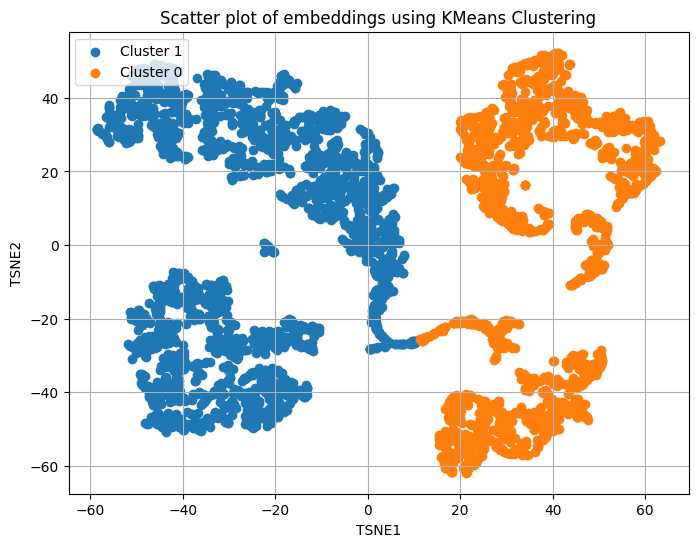

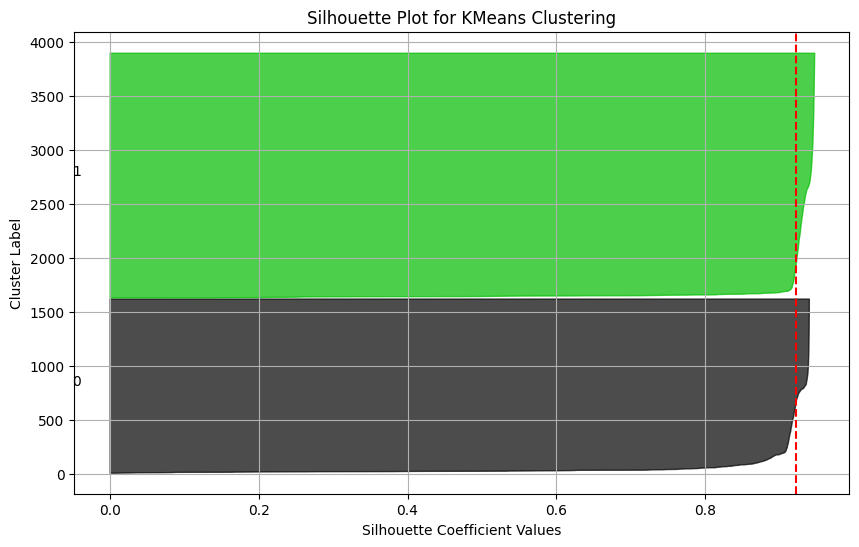

In [23]:
trainer.plot_tsne(test_loader)

Evaluating:   0%|          | 0/243 [00:00<?, ?it/s]

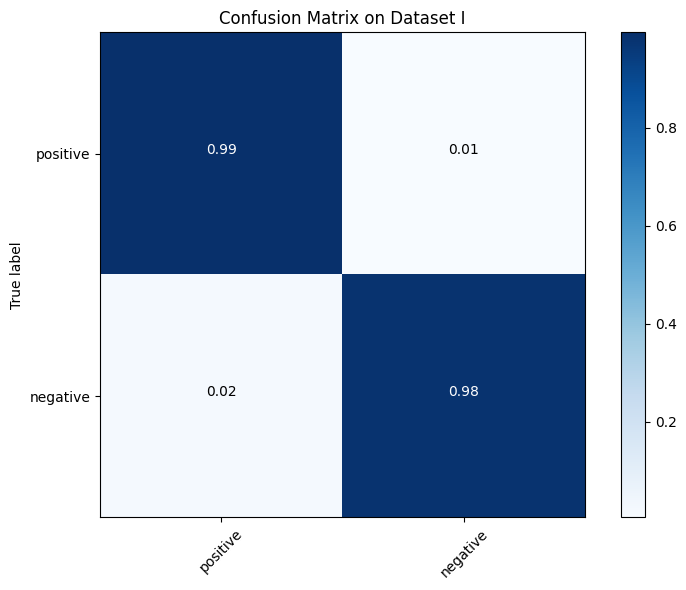

In [24]:
trainer.plot_confusion_matrix(test_loader,normalize=True)

In [25]:
torch.save(model, "TriFusion_model_900repo_nothing.pth")

In [26]:
#发送多种类型的邮件
from email.mime.multipart import MIMEMultipart
import smtplib

from email.mime.text import MIMEText
msg_from = '915803745@qq.com'  # 发送方邮箱
passwd = 'vcuosuurrgkfbdai'   #就是上面的授权码
 
# to= ['g.zhang@gotion.com', 'j.tong@gotion.com'] #接受方邮箱
to= ['j.tong@gotion.com'] #接受方邮箱
#设置邮件内容
#MIMEMultipart类可以放任何内容
msg = MIMEMultipart()
conntent=f"{classification_report(test_labels, test_preds, digits=4)}"
#把内容加进去
msg.attach(MIMEText(conntent,'plain','utf-8'))
 
#设置邮件主题
msg['Subject']="强化学习模型训练完毕"
 
#发送方信息
msg['From']=msg_from
 
#开始发送
 
#通过SSL方式发送，服务器地址和端口
s = smtplib.SMTP_SSL("smtp.qq.com", 465)
# 登录邮箱
s.login(msg_from, passwd)
#开始发送
s.sendmail(msg_from,to,msg.as_string())
print("强化学习模型训练完毕")

强化学习模型训练完毕


In [27]:
1

1